In [21]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
keras = tf.keras
import utils 
from importlib import reload 
print(tf.__version__)
reload(utils)

2.3.0


<module 'utils' from 'C:\\SongyanHou\\Study\\Codes\\DeepHedging\\utils.py'>

In [23]:
N = 100 # time disrectization    
S0 = 1.0 # initial value of the asset
T = 0.25 # maturity
dt = T / 100
strike = 1.1
payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
option_type = 'eurocall'
strike_modified = 1.3
po = np.inf
if po == np.inf:
    payoff_function_modified = lambda x : 0.5*(np.abs(x-strike_modified)+x-strike_modified) 
if po == 1:
    payoff_function_modified = lambda x : (x-strike) * (x > strike_modified) 


### Generate paths

#### Black-Scholes
$$
dS_{t}=\sigma S_{t}\,dW_{t}
$$

In [24]:
m = 1 # dimension of price
mu = 0.08
sigma = 0.3
Ktrain = 10**5
price_path, time_grid = utils.simulate_GBM(m,Ktrain,N,T,mu,sigma,S0, 'equi')

real premium: 0.002766


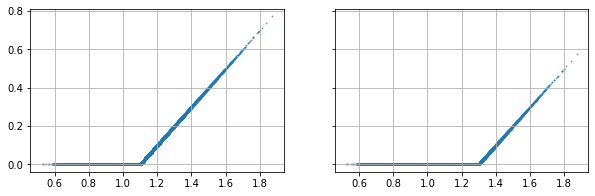

In [25]:
payoff = payoff_function(price_path[:,-1]) 
payoff_modified = payoff_function_modified(price_path[:,-1]) 
if po == np.inf:
    delta_output, delta_path, option_path = utils.delta_hedge(price_path,payoff_modified,T,strike_modified,sigma,option_type,time_grid)
    initial_wealth,_ = utils.BlackScholes(T, S0, strike_modified, sigma, option_type)
else:
    initial_wealth = payoff_modified.mean()
    
print(f"real premium: {initial_wealth:{1}.{4}}")           # real premium

f,p = plt.subplots(1,2, figsize = [10,3], sharey = True)
p[0].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'payoff')
p[1].scatter(price_path[:,-1,0], payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
p[0].grid()
p[1].grid()
plt.show()

### Build the deep hedging dynamic 

Value process
$$
V_{t} = \int_{0}^{t}H_{t}dS_{t} + \alpha \int_{0}^{t}(S_{t}dH_{t})^{2} \cdot \text{(trans_cost =True)}
$$
Objective function
\begin{equation}
\begin{split}
\min_{H_{t}}\quad & E\bigg[(f(S_{T})-V_{T})^2\bigg] \\
+ &\beta E\bigg[\int_{0}^{T}(C_{t} - V_{t})^{2}dt\bigg] \cdot \text{(control_path =True)}
\end{split}
\end{equation}

where $(C_{t})_{t\geq 0}$ is the call option price and $f$ is the payoff function.

In [26]:
def build_dynamic(m, N, control_path, trans_cost, model_type):
    
    L = 3 # number of layers in strategy
    n = m + 10  # nodes in the first but last layers
    Networks = utils.build_network(m, n , L, N)
    Network0 = keras.layers.Dense(1, use_bias=False)

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    payoff = keras.Input(shape=(1))
    if control_path:
        inputs = [price, payoff, benchmark_hedge]
    else:
        inputs = [price, payoff]
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
#     premium = Network0(tf.ones_like(price[:,0,:1])) # premium; (batch, 1)
    premium = initial_wealth

    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:])
    STRATEGY = [None]*N
    ADMISSIBLE = tf.zeros_like(price[:,0,:])
    
    for j in range(N):
        I = tf.math.log(price[:,j,:])
        STRATEGY[j] = Networks[j](I) # H_{t} = nn(S_{t}); (batch, m)
        
        cost = 0
        if trans_cost and j > 0: 
            cost = 0.005*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
            
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
        ADMISSIBLE = tf.math.minimum(ADMISSIBLE, HEDGE[j+1] + premium)
      
    outputs = premium + tf.math.reduce_sum(HEDGE[-1],axis = -1, keepdims = True) # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
    
    model_hedge = keras.Model(inputs = inputs, outputs=outputs)

# Define LOSS
    
    
#     mse = tf.keras.losses.MeanSquaredError()
#     model_hedge.add_loss(mse(outputs, payoff))   

#     alpha = 0.99
#     loss = premium + 1/(1 - alpha)*tf.nn.relu(payoff - outputs)
#     loss = tf.reduce_mean(loss)
#     model_hedge.add_loss(loss)  

#     loss = tf.nn.relu(payoff - outputs)
#     loss = (loss)**p
#     loss = tf.clip_by_value(loss,0,10000)
#     loss = tf.reduce_mean(loss)
#     model_hedge.add_loss(loss) 
    if po == np.inf:
        loss = tf.math.reduce_max(tf.nn.relu(payoff - outputs),keepdims = True)
    else:
        loss = (tf.nn.relu(payoff - outputs))**po
    loss = tf.clip_by_value(loss,0,10000) 
    model_hedge.add_loss(tf.reduce_mean(loss)) 
    
#     loss = tf.math.sign(-ADMISSIBLE)
    loss = -ADMISSIBLE*50
    loss = tf.clip_by_value(loss,0,10000)
    model_hedge.add_loss(tf.reduce_mean(loss)) 
    model_hedge.add_metric(loss, name='0-ad-loss')
    
    loss = (outputs - payoff)*10
    loss = tf.clip_by_value(loss,0,10000)
    model_hedge.add_loss(tf.reduce_mean(loss)) 
    model_hedge.add_metric(loss, name='up-ad-loss')
    
    if control_path:
        for j in range(N):
            mse = tf.keras.losses.MeanSquaredError()
            model_hedge.add_loss(10*mse(HEDGE[j]+premium, benchmark_hedge[:,j]))   
    
    return model_hedge, Network0, Networks


In [27]:
m = 1
model_hedge, Network0, Networks = build_dynamic(m, N, False, False, 'BS')

### Train the model

In [28]:
def prepare_data(price_path, payoff):    
    control_path = False
    if not control_path:
        option_path = price_path
    split = int(Ktrain/2)
    xtrain = [price_path[:split], payoff[:split], option_path[:split]]  # input be price_path
    ytrain = payoff[:split]*0  # output be payoff
    xtest = [price_path[split:], payoff[:split], option_path[split:]]  # input be price_path
    ytest = payoff[split:]*0  # output be payoff
    return xtrain, ytrain, xtest, ytest

In [29]:
def zeroloss(y_true, y_predict):
    return tf.reduce_sum(y_predict*0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
# model_hedge.compile(optimizer = optimizer,loss='mse') # specify the mean square loss 
model_hedge.compile(optimizer = optimizer,loss=zeroloss) # specify the expected shortfall

### Hedge the payoff

In [30]:
xtrain, ytrain, xtest, ytest = prepare_data(price_path, payoff)
model_hedge.fit(x=xtrain,y=ytrain, epochs=20,verbose=True,batch_size=256) # train the model 

Epoch 1/20
196/196 [==============================] - 11s 57ms/step - loss: 0.5473 - 0-ad-loss: 0.2638 - up-ad-loss: 0.0170
Epoch 2/20
196/196 [==============================] - 12s 59ms/step - loss: 0.3958 - 0-ad-loss: 0.1300 - up-ad-loss: 0.0093
Epoch 3/20
196/196 [==============================] - 12s 60ms/step - loss: 0.3507 - 0-ad-loss: 0.0868 - up-ad-loss: 0.0078
Epoch 4/20
196/196 [==============================] - 12s 62ms/step - loss: 0.3269 - 0-ad-loss: 0.0677 - up-ad-loss: 0.0067
Epoch 5/20
196/196 [==============================] - 13s 66ms/step - loss: 0.3218 - 0-ad-loss: 0.0605 - up-ad-loss: 0.0064
Epoch 6/20
196/196 [==============================] - 13s 69ms/step - loss: 0.3136 - 0-ad-loss: 0.0564 - up-ad-loss: 0.0062
Epoch 7/20
196/196 [==============================] - 14s 72ms/step - loss: 0.3052 - 0-ad-loss: 0.0522 - up-ad-loss: 0.0056
Epoch 8/20
196/196 [==============================] - 14s 72ms/step - loss: 0.3040 - 0-ad-loss: 0.0494 - up-ad-loss: 0.0057
Epoch 9/

In [31]:
hedge_output_train = model_hedge.predict(xtrain) # compute the output (deep replicate payoff) with trained model 
hedge_output_test = model_hedge.predict(xtest) # compute the output (deep replicate payoff) with trained model

In [32]:
def ploss(payoff, outputs):
    if po == np.inf:
        loss = tf.math.reduce_max(tf.nn.relu(payoff - outputs),keepdims = True)
    else:
        loss = (tf.nn.relu(payoff - outputs))**po
    loss = (tf.reduce_mean(loss))
    return loss
print('train: ',ploss(payoff[:int(Ktrain/2)], hedge_output_train).numpy())
print('test: ',ploss(payoff[int(Ktrain/2):], hedge_output_test).numpy())
print('best: ',ploss(payoff, payoff_modified).numpy())

train:  0.3296099256756251
test:  0.3382940370246468
best:  0.20000000000000007


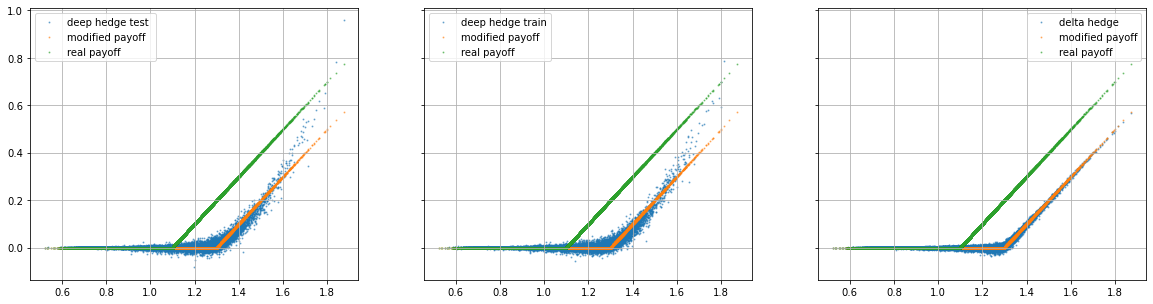

In [33]:
f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
p[0].scatter(price_path[int(Ktrain/2):,-1,0], hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
p[1].scatter(price_path[:int(Ktrain/2),-1,0], hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
if po == np.inf:
    p[2].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
for i in range(3):
    p[i].scatter(price_path[:,-1,0], payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
    p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
    p[i].legend()
    p[i].grid()

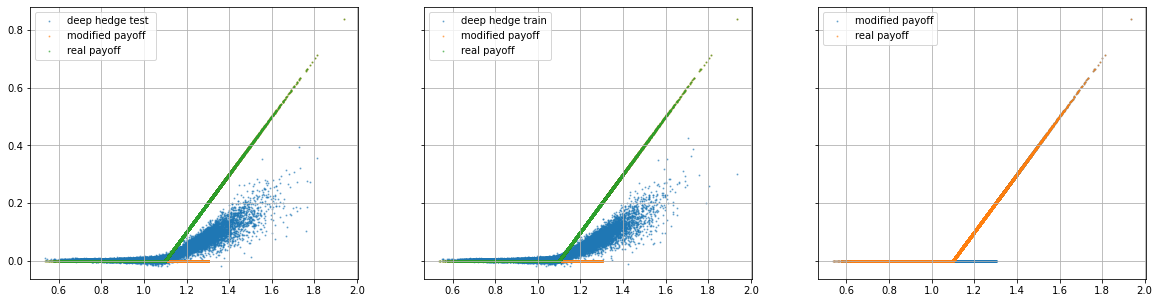

In [12]:
f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
p[0].scatter(price_path[int(Ktrain/2):,-1,0], hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
p[1].scatter(price_path[:int(Ktrain/2),-1,0], hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
if po == np.inf:
    p[2].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
for i in range(3):
    p[i].scatter(price_path[:,-1,0], payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
    p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
    p[i].legend()
    p[i].grid()

In [13]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

### History

In [14]:
# print(f"deep premium: {Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{4}}")         # premium of deep hedge (truncted printing)
# helper,_ = utils.BlackScholes(T, S0, strike, sigma, option_type)
# print(f"real premium: {helper:{1}.{4}}")           # real premium

In [15]:
# plt.hist(hedge_output_train[:,0] - ytrain[:,0],bins = 100)
# plt.show()

In [16]:
# f,p = plt.subplots(1,5,figsize = [20,5])
# for i in range(5):
#     n = 20*i + 10
#     pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

#     he = Networks[n](pr) # the stategy network 
#     p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy

#     _,delta = utils.BlackScholes(T - time_grid[n], pr, strike, sigma, option_type)
#     p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
#     p[i].title.set_text(f"At time: {time_grid[n]:{1}.{4}}")
#     p[i].legend()
#     p[i].grid()
# plt.show()

In [17]:
# Hedge = [None] * N
# transaction_cost = 0
# for j in range(N):
#     Hedge[j] = Networks[j](price_path[:,j,:])
#     if j > 0: 
#         transaction_cost += 0.005*(Hedge[j]*price_path[:,j-1,:] - Hedge[j-1]*price_path[:,j-1,:])**2
# print(transaction_cost[:,0].numpy().mean())
# plt.hist(transaction_cost[:,0].numpy())